In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import pyproj

In [45]:
df = pd.read_csv('zori_county_most_recent_clean.csv')
df

,name,fips,lat,lng,pop_2023,date,zori,zori_1yc,zori_5yc
0,"Los Angeles County, CA",6037,34.067886,-118.245990,9663345,2024-10-31,2864.485813,2.609013,23.128455
1,"Cook County, IL",17031,41.869515,-87.757998,5087072,2024-10-31,2050.046257,4.776920,25.058926
2,"Harris County, TX",48201,29.816889,-95.425716,4835125,2024-10-31,1661.050802,2.743027,23.412405
3,"Maricopa County, AZ",4013,33.490147,-112.044016,4585871,2024-10-31,1834.325759,0.792236,41.146645
4,"San Diego County, CA",6073,32.884418,-117.112348,3269973,2024-10-31,3016.945905,1.815604,40.769392
...,...,...,...,...,...,...,...,...,...
1139,"Valley County, ID",16085,44.766234,-116.074739,12644,2024-10-31,2422.222222,NaN,NaN
1140,"Blanco County, TX",48031,30.177148,-98.392080,13048,2024-10-31,1522.500000,NaN,NaN
1141,"Barnes County, ND",38003,46.926891,-98.030382,10726,2024-10-31,675.000000,NaN,NaN
1142,"Clear Creek County, CO",8019,39.713458,-105.532527,9147,2024-10-31,2141.666667,NaN,NaN


In [46]:
def prepare_county_data(df):
    """
    Prepare county data with updated bubble sizing.
    
    Parameters:
    df: DataFrame with columns ['name', 'fips', 'lat', 'lng', 'pop_2023']
    
    Returns:
    GeoDataFrame with projected coordinates and bubble sizes
    """
    # Convert FIPS to string and ensure 5 digits with leading zeros
    df = df.copy()
    df['fips'] = df['fips'].astype(str).str.zfill(5)
    
    # Filter out Alaska (02), Hawaii (15), and territories
    continental_fips = df[~df['fips'].str[:2].isin(['02', '15', '60', '66', '69', '72', '78'])]
    
    print(f"Filtered out {len(df) - len(continental_fips)} non-continental US counties")
    print(f"Remaining counties: {len(continental_fips)}")
    
    # Create geometry from lat/lng
    geometry = [Point(xy) for xy in zip(continental_fips['lng'], continental_fips['lat'])]
    
    # Create initial GeoDataFrame
    gdf = gpd.GeoDataFrame(continental_fips, geometry=geometry, crs="EPSG:4326")
    
    # Project to USA Contiguous Albers Equal Area Conic
    gdf = gdf.to_crs("EPSG:5070")
    
    # Extract projected coordinates
    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y
    
    # Scale coordinates to more manageable numbers (divide by 1000 for kilometers)
    gdf['x'] = gdf['x'] / 1000
    gdf['y'] = gdf['y'] / 1000
    
    # Calculate bubble sizes
    max_pop = continental_fips['pop_2023'].max()
    x_range = gdf['x'].max() - gdf['x'].min()
    target_max_radius = x_range * 0.05  # Updated to 5% as requested
    
    # Calculate scaling factor to achieve target maximum radius
    scaling_factor = target_max_radius / np.sqrt(max_pop)
    
    # Apply scaling to all bubbles
    gdf['bubble_radius'] = np.sqrt(continental_fips['pop_2023']) * scaling_factor
    
    # Keep only necessary columns
    cols_to_keep = ['name', 'fips', 'x', 'y', 'bubble_radius', 'pop_2023', 
                    'zori', 'zori_1yc', 'zori_5yc', 'geometry']
    gdf = gdf[cols_to_keep]
    
    print("\nScaling Summary:")
    print(f"Max population: {max_pop:,.0f}")
    print(f"Target max radius: {target_max_radius:.2f}")
    print(f"Scaling factor: {scaling_factor:.6f}")
    print(f"Min radius: {gdf['bubble_radius'].min():.2f}")
    print(f"Max radius: {gdf['bubble_radius'].max():.2f}")
    
    return gdf

In [47]:
processed_gdf = prepare_county_data(df)

Filtered out 9 non-continental US counties
Remaining counties: 1135

Scaling Summary:
Max population: 9,663,345
Target max radius: 221.62
Scaling factor: 0.071292
Min radius: 6.12
Max radius: 221.62


In [48]:
from scipy.spatial import cKDTree

In [49]:
class DorlingLayout:
    def __init__(self, gdf, position_force=0.1, collision_force=1.0, max_iterations=100):
        """
        Initialize the Dorling cartogram layout algorithm.
        
        Parameters:
        gdf: GeoDataFrame with 'x', 'y', 'bubble_radius' columns
        position_force: Force pulling bubbles back to original positions (0-1)
        collision_force: Force pushing overlapping bubbles apart (>0)
        max_iterations: Maximum number of iterations to run
        """
        self.original_positions = np.column_stack((gdf.x, gdf.y))
        self.current_positions = self.original_positions.copy()
        self.radii = gdf['bubble_radius'].values
        self.position_force = position_force
        self.collision_force = collision_force
        self.max_iterations = max_iterations
        
    def _detect_collisions(self):
        """Find all pairs of overlapping bubbles using KD-tree for efficiency."""
        tree = cKDTree(self.current_positions)
        
        # Find all pairs of points within max possible collision distance
        max_diameter = max(self.radii) * 2
        pairs = tree.query_pairs(max_diameter)
        
        collisions = []
        for i, j in pairs:
            dist = np.linalg.norm(self.current_positions[i] - self.current_positions[j])
            combined_radius = self.radii[i] + self.radii[j]
            if dist < combined_radius:
                collisions.append((i, j, dist, combined_radius))
        
        return collisions
    
    def _apply_forces(self):
        """Apply both collision resolution and position retention forces."""
        # Initialize displacement vector
        displacement = np.zeros_like(self.current_positions)
        
        # Handle collisions
        collisions = self._detect_collisions()
        for i, j, dist, combined_radius in collisions:
            if dist < 0.0001:  # Prevent division by zero
                # If bubbles are exactly on top of each other, move them slightly apart
                angle = np.random.random() * 2 * np.pi
                displacement[i] += np.array([np.cos(angle), np.sin(angle)])
                displacement[j] -= np.array([np.cos(angle), np.sin(angle)])
                continue
                
            # Calculate overlap
            overlap = combined_radius - dist
            
            # Calculate unit vector from j to i
            direction = (self.current_positions[i] - self.current_positions[j]) / dist
            
            # Apply forces proportional to circle sizes
            force_i = overlap * self.collision_force * (self.radii[i] / combined_radius)
            force_j = overlap * self.collision_force * (self.radii[j] / combined_radius)
            
            displacement[i] += direction * force_i
            displacement[j] -= direction * force_j
        
        # Apply force pulling back to original positions
        position_diff = self.original_positions - self.current_positions
        displacement += position_diff * self.position_force
        
        return displacement
    
    def layout(self, convergence_threshold=0.1):
        """
        Run the layout algorithm until convergence or max iterations.
        
        Parameters:
        convergence_threshold: Stop if max displacement is below this value
        
        Returns:
        numpy array of final positions, number of iterations run
        """
        for iteration in range(self.max_iterations):
            # Calculate and apply forces
            displacement = self._apply_forces()
            
            # Update positions
            self.current_positions += displacement
            
            # Check for convergence
            max_displacement = np.max(np.abs(displacement))
            if max_displacement < convergence_threshold:
                print(f"Converged after {iteration + 1} iterations")
                break
                
        return self.current_positions, iteration + 1

def apply_dorling_layout(gdf, position_force=0.1, collision_force=1.5, max_iterations=300):
    """
    Apply Dorling layout with stronger collision prevention and guaranteed spacing.
    
    Parameters:
    gdf: GeoDataFrame with 'x', 'y', 'bubble_radius' columns
    position_force: Force pulling bubbles back to original positions (0-1)
    collision_force: Force pushing overlapping bubbles apart (>0)
    max_iterations: Maximum number of iterations to run
    """
    # Add a buffer between bubbles (10% extra space between bubbles)
    buffer_factor = 1.1
    
    # Create temporary GeoDataFrame with buffered radii for layout
    temp_gdf = gdf.copy()
    temp_gdf['bubble_radius'] = gdf['bubble_radius'] * buffer_factor
    
    # Run layout algorithm with stronger collision force and lower convergence threshold
    layout = DorlingLayout(temp_gdf, position_force, collision_force, max_iterations)
    final_positions, iterations = layout.layout(convergence_threshold=0.01)
    
    # Create new GeoDataFrame with updated positions
    result_gdf = gdf.copy()
    result_gdf['x'] = final_positions[:, 0]
    result_gdf['y'] = final_positions[:, 1]
    
    # Update geometry to reflect new positions
    result_gdf['geometry'] = [Point(x, y) for x, y in final_positions]
    
    print(f"Layout completed in {iterations} iterations")
    
    # Verify no overlaps
    tree = cKDTree(final_positions)
    pairs = tree.query_pairs(2 * temp_gdf['bubble_radius'].max())
    overlaps = 0
    for i, j in pairs:
        dist = np.linalg.norm(final_positions[i] - final_positions[j])
        combined_radius = gdf.iloc[i]['bubble_radius'] + gdf.iloc[j]['bubble_radius']
        if dist < combined_radius:
            overlaps += 1
    
    print(f"Number of overlapping pairs: {overlaps}")
    
    return result_gdf
# Example usage:
adjusted_gdf = apply_dorling_layout(processed_gdf)

Layout completed in 300 iterations
Number of overlapping pairs: 759


In [50]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import mplcursors
import numpy as np

def visualize_dorling(adjusted_gdf, figsize=(15, 10)):
    """
    Create an interactive visualization of the Dorling cartogram with debugging features.
    
    Parameters:
    adjusted_gdf: GeoDataFrame with adjusted positions
    figsize: Tuple of figure dimensions
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Print some diagnostic information
    print("Data Statistics:")
    print(f"Number of counties: {len(adjusted_gdf)}")
    print("\nCoordinate ranges:")
    print(f"X range: {adjusted_gdf.x.min():,.0f} to {adjusted_gdf.x.max():,.0f}")
    print(f"Y range: {adjusted_gdf.y.min():,.0f} to {adjusted_gdf.y.max():,.0f}")
    print(f"Bubble radius range: {adjusted_gdf.bubble_radius.min():,.0f} to {adjusted_gdf.bubble_radius.max():,.0f}")
    
    # Calculate bounds with some padding
    x_min, x_max = adjusted_gdf.x.min(), adjusted_gdf.x.max()
    y_min, y_max = adjusted_gdf.y.min(), adjusted_gdf.y.max()
    padding = max(adjusted_gdf.bubble_radius.max() * 2, (x_max - x_min) * 0.05)
    
    # Set up the axis with calculated bounds
    ax.set_aspect('equal')
    ax.set_title('County Population Dorling Cartogram', fontsize=14, pad=20)
    ax.set_xlim(x_min - padding, x_max + padding)
    ax.set_ylim(y_min - padding, y_max + padding)
    
    # Add a reference point at origin for debugging
    ax.plot(0, 0, 'r+', markersize=10, label='Origin')
    
    # Create circles with better styling
    circles = []
    for idx, row in adjusted_gdf.iterrows():
        # Print first few circles for debugging
        if idx < 5:
            print(f"\nCounty {idx} - {row['name']}:")
            print(f"Position: ({row.x:.0f}, {row.y:.0f})")
            print(f"Radius: {row.bubble_radius:.0f}")
            
        circle = Circle((row.x, row.y), row.bubble_radius, 
                       facecolor='#1f77b4', alpha=0.6, 
                       edgecolor='white', linewidth=0.5)
        ax.add_patch(circle)
        circles.append(circle)
    
    # Add interactive hover tooltips
    cursor = mplcursors.cursor(circles, hover=True)
    
    @cursor.connect("add")
    def on_hover(sel):
        circle_index = circles.index(sel.artist)
        county_data = adjusted_gdf.iloc[circle_index]
        pop_str = f"{county_data['pop_2023']:,.0f}"
        sel.annotation.set_text(
            f"{county_data['name']}\nPopulation: {pop_str}"
        )
    
    # Add grid for reference
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    return fig

# Let's also add a quick check of the processed data before visualization
def check_data_validity(gdf):
    """Check if the GeoDataFrame has valid data for visualization"""
    required_cols = ['x', 'y', 'bubble_radius', 'name', 'pop_2023']
    
    # Check columns exist
    missing_cols = [col for col in required_cols if col not in gdf.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return False
    
    # Check for null values
    null_counts = gdf[required_cols].isnull().sum()
    if null_counts.any():
        print("Warning: Found null values:")
        print(null_counts[null_counts > 0])
        return False
    
    # Check for zero or negative values in bubble_radius
    if (gdf['bubble_radius'] <= 0).any():
        print("Error: Found zero or negative bubble radii")
        return False
    
    return True

Filtered out 9 non-continental US counties
Remaining counties: 1135

Scaling Summary:
Max population: 9,663,345
Target max radius: 221.62
Scaling factor: 0.071292
Min radius: 6.12
Max radius: 221.62
Layout completed in 100 iterations
Number of overlapping pairs: 920
Data Statistics:
Number of counties: 1135

Coordinate ranges:
X range: -2,451 to 2,285
Y range: 246 to 3,167
Bubble radius range: 6 to 222

County 0 - Los Angeles County, CA:
Position: (-2415, 1374)
Radius: 222

County 1 - Cook County, IL:
Position: (1632, 1265)
Radius: 161

County 2 - Harris County, TX:
Position: (315, 585)
Radius: 157

County 3 - Maricopa County, AZ:
Position: (-1540, 1299)
Radius: 153

County 4 - San Diego County, CA:
Position: (-1899, 1131)
Radius: 129


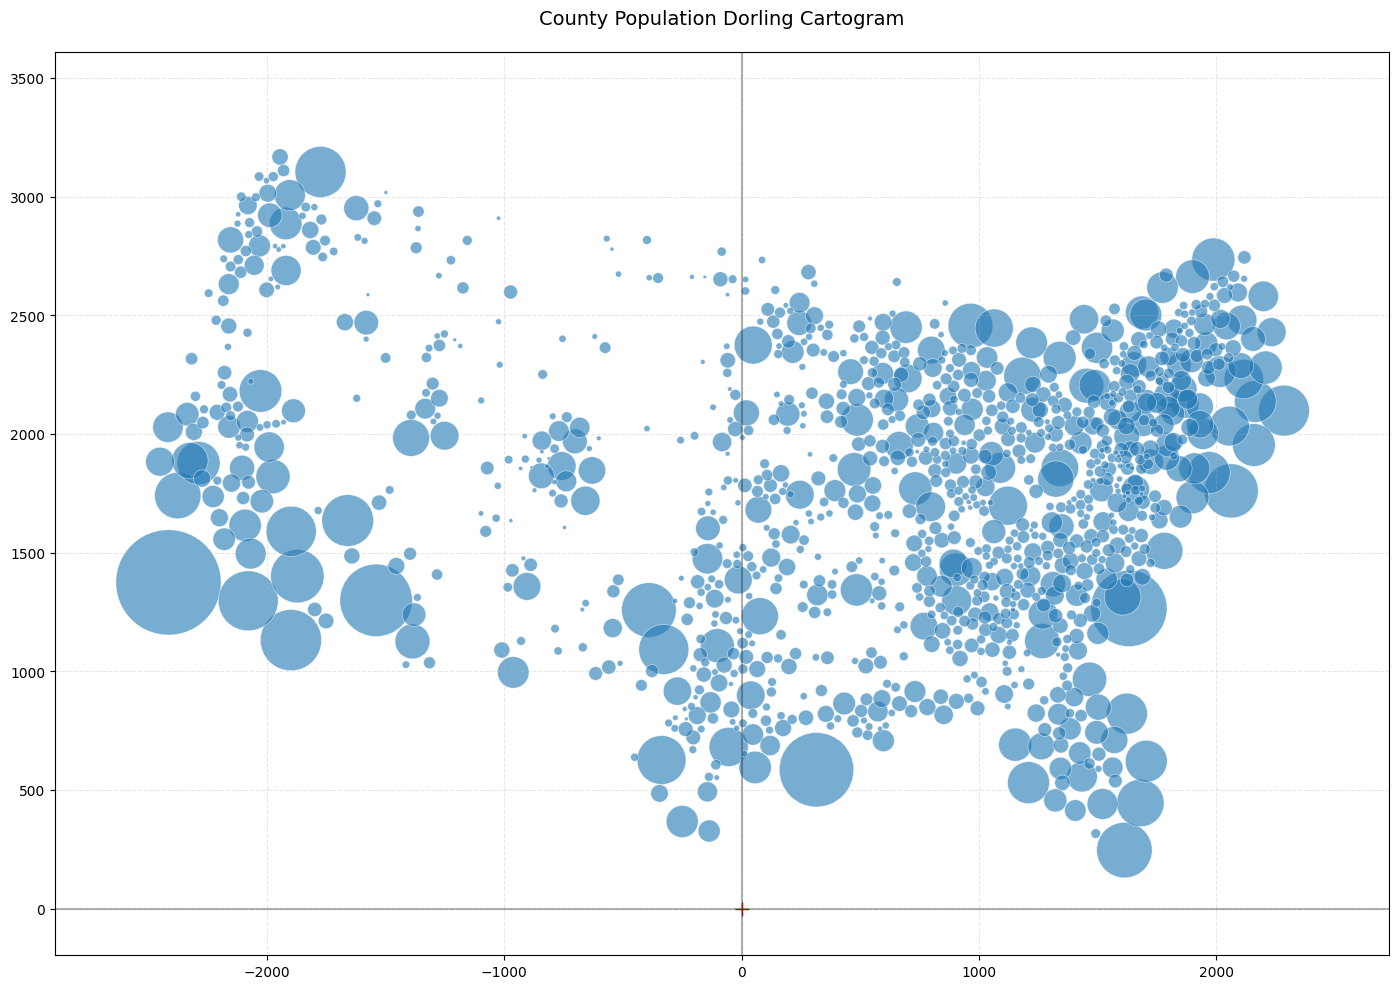

In [51]:
# Process the original data
processed_gdf = prepare_county_data(df)

# Verify data is valid
if check_data_validity(processed_gdf):
    # Apply the Dorling layout
    adjusted_gdf = apply_dorling_layout(
        processed_gdf,
        position_force=0.1,
        collision_force=1.0,
        max_iterations=100
    )
    
    # Create the interactive visualization with debugging info
    fig = visualize_dorling(adjusted_gdf)
    plt.show()
else:
    print("Please fix data issues before visualization")